In [1]:
""" Implements a CNN to recognize hand-written digits.
Data: https://www.kaggle.com/c/digit-recognizer/data > train.csv
"""

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchsummary import summary

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

IN_PATH = "../data/"
OUT_PATH = "../data/models/"


In [3]:
class Digits(Dataset):

    def __init__(self, path_to_data):
        data = np.genfromtxt(
            path_to_data, delimiter=",", skip_header=True)
        self.image = torch.from_numpy(
            data[:, 1:]).float().view(-1, 1, 28, 28).to(device)
        self.label = torch.from_numpy(data[:, 0:1]).long().squeeze().to(device)

    def __len__(self):
        return len(self.image)

    def __getitem__(self, index):
        return self.image[index], self.label[index]


dataset = Digits(IN_PATH+"digit-recognizer-train.csv")


In [4]:
train_size = int(0.5 * len(dataset))
valid_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - valid_size
print(train_size)
print(valid_size)
print(test_size)
batch_size = 10
train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(
    dataset, (train_size, valid_size, test_size))

train_dataset_generator = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataset_generator = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_dataset_generator = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


21000
8400
12600


In [5]:
class Recognizer(nn.Module):
    def __init__(self):
        super(Recognizer, self).__init__()
        # Input (-1, 1, 28, 28)
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=1)
        self.drop1 = nn.Dropout2d(p=0.5)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=1)
        self.drop2 = nn.Dropout2d(p=0.5)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.new_size = 64 * 5 * 5
        self.fc1 = torch.nn.Linear(self.new_size, 64)
        self.drop3 = nn.Dropout(p=0.5)
        self.fc2 = torch.nn.Linear(64, 10)
        self.train_loss = []
        self.valid_loss = []
        self.test_loss = []

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.drop1(x)
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.drop2(x)
        x = self.pool2(x)
        x = x.view(-1, self.new_size)
        x = F.relu(self.fc1(x))
        x = self.drop3(x)
        x = self.fc2(x)
        return x


In [6]:
lr, momentum, epochs = 0.001, 0.0001, 75
recognizer = Recognizer().to(device)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(recognizer.parameters(), lr=lr, momentum=momentum)
summary(recognizer, (1, 28, 28))
min_valid_loss = np.inf


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             832
         Dropout2d-2           [-1, 32, 26, 26]               0
         MaxPool2d-3           [-1, 32, 13, 13]               0
            Conv2d-4           [-1, 64, 11, 11]          51,264
         Dropout2d-5           [-1, 64, 11, 11]               0
         MaxPool2d-6             [-1, 64, 5, 5]               0
            Linear-7                   [-1, 64]         102,464
           Dropout-8                   [-1, 64]               0
            Linear-9                   [-1, 10]             650
Total params: 155,210
Trainable params: 155,210
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.50
Params size (MB): 0.59
Estimated Total Size (MB): 1.10
-------------------------------------------

In [7]:
for _ in range(epochs):
    local_errors = []
    recognizer.train()
    for imgs, labels in train_dataset_generator:
        error = loss(recognizer(imgs), labels)
        local_errors.append(error.item())
        optimizer.zero_grad()
        error.backward()
        optimizer.step()
    train_loss = np.mean(local_errors)
    recognizer.train_loss.append(train_loss)

    local_errors = []
    recognizer.eval()
    with torch.no_grad():
        for imgs, labels in valid_dataset_generator:
            error = loss(recognizer(imgs), labels)
            local_errors.append(error.item())
        valid_loss = np.mean(local_errors)
        recognizer.valid_loss.append(valid_loss)

        if min_valid_loss > valid_loss:
            min_valid_loss = valid_loss
            torch.save(recognizer.state_dict(),
                       OUT_PATH+"recognizer_tmp.pt")


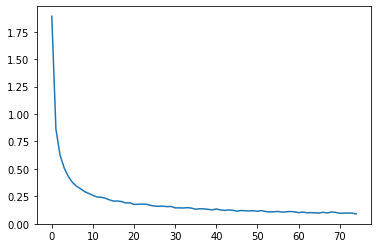

In [8]:
plt.plot(recognizer.train_loss)


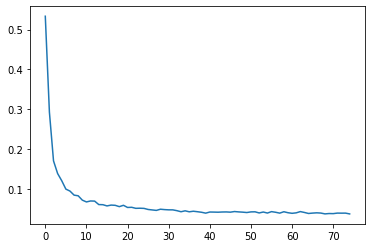

In [9]:
plt.plot(recognizer.valid_loss)


In [11]:
recognizer.eval()
with torch.no_grad():
    local_errors = []
    for imgs, labels in test_dataset_generator:
        error = loss(recognizer(imgs), labels)
        local_errors.append(error.item())
    test_loss = np.mean(local_errors)
    recognizer.test_loss.append(test_loss)


In [12]:
recognizer.test_loss[-1]


0.04497581344200932